# Heterogeneous IHC model
Hetergeneity comes from giving each agents a unique skillset and computing probabilities based on their fitness with a given job vacancy.

We also make experiments for the Direct Recommender system and homophilic networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
from scipy.stats import poisson
# parallel computing
from itertools import product
from functools import partial
from joblib import Parallel, delayed

# local libraries
import sys
sys.path.append("../src")
from model import IndependentHaltingCascade as IHC
from network_generators.erdos_renyi import generate_erdos_renyi_edgelist
from network_generators.oracle import generate_oracle
from network_generators.homophilic import generate_homophilic_network_edgelist, onehot_encode_skills
from skills_and_vacancies import sample_application_and_hiring_probs, sample_skills, sample_skills_correlated, majority_groups
from utils.simulation_helpers import run_model, perform_independent_model_simulations, save_experiment
import utils.simulation_helpers as sh
from utils.graphtool_reader import import_graphtool_network

In [31]:
## TODO: Delete ##

# ## plotting style ##
# import matplotlib as mpl
# # Customize font sizes for different elements
# title_font_size = 16
# label_font_size = 14
# tick_font_size = 12
# legend_font_size = 11

# # Set font sizes for title, labels, and ticks
# mpl.rcParams['axes.titlesize'] = title_font_size
# mpl.rcParams['axes.labelsize'] = label_font_size
# mpl.rcParams['xtick.labelsize'] = tick_font_size
# mpl.rcParams['ytick.labelsize'] = tick_font_size
# mpl.rcParams['legend.fontsize'] = legend_font_size

# # Some nice plotting colors
# cs = [
#     "#4169E1",  # Royal Blue
#     "#DC143C",  # Crimson
#     "#228B22",  # Forest Green
#     "#FF8C00",  # Dark Orange
#     "#800080",  # Purple
#     "#008080",  # Teal
#     "#808000",  # Olive
#     "#708090",  # Slate Gray
#     "#FF1493",  # Deep Pink
#     "#8B0000"   # Dark Red
# ]

# # linestyles
# ls = ['dotted', '--', '-']

In [8]:
## Global parameters
# Network
N_NODES = 2000
K_AVG = 20
ORACLE_REACH = 0.5
ORACLE_DEGREE = round(N_NODES * ORACLE_REACH)
ER_GENERATOR = lambda: generate_erdos_renyi_edgelist(n_nodes=N_NODES, prob_edge=K_AVG/N_NODES)
BA_GENERATOR = lambda: generate_barabasi_albert(N_NODES, K_AVG)
ORACLE_GENERATOR = lambda: generate_oracle(N_NODES, ORACLE_DEGREE)

# IHC (with skills)
AVG_SKILLS = 3
CIs = [0.5, 0.9, 0.99] # confidence intervals
VACANCY_REQUIREMENTS = [int(poisson.interval(CI, AVG_SKILLS)[1]) for CI in CIs] # [4,6,8]

# IHC (homogeneous)
P_RECOMMENDATION = 0.1
P_APPLICATION = 0.25 # same as Milgram's dropout rate
P_HIRING = 0.1

# Homophily and skill correlations
ALPHA = 0.5 # Dirichlet param. for correlated skills (0.1 => very correlated, 5 => very uncorrelated)
N_SKILL_GROUPS = 3
HOMOPHILY = 6 # (1 => low homophily, 6 => high homophily, np.inf => extreme homophily)

# Real networks
REAL_NETWORK_SELECTION = [
    "copenhagen/sms", # directed, phone sms, n=568, m=24k
    "uni_email", # directed, email exchanges, n=1.1k, m=10k
    "twitter_15m", # directed, followerships, n=87k, m=6M
]

# grid
N_SIMULATIONS = 200
NEW_EDGELIST_EVERY = N_SIMULATIONS // 10

# saving
PATH = '../results/data/heterogeneous'
# FN_SUFFIX = 'n_nodes={n_nodes}-k_avg={k_avg}_ph={ph}.npy'
FN_SUFFIX = 'n_nodes={n_nodes}-k_avg={k_avg}_pr={pr}-avg_skills={avg_skills}-requirements={requirements}.npy'
FN_SUFFIX_CORR = 'n_nodes={n_nodes}-k_avg={k_avg}_pr={pr}-avg_skills={avg_skills}-requirements={requirements}-alpha={alpha}-n_skillgroups={n_skillgroups}_homophily={homophily}.npy'

In [5]:
## Skill-specific model runner
def run_model_skills(edgelist, λ, nν, n_skills=None, nodelist=None, **kw):
    if nodelist is None:
        nodelist = list( set(edgelist['source']).union(edgelist['target']) )
    pa, ph = sample_application_and_hiring_probs(nodelist, λ, nν, n_skills)
    return run_model(edgelist, application_probs=pa, hiring_probs=ph, **kw)

### Oracle-specific model runner
def run_model_oracle_skills(edgelist, λ, nν, n_skills=None, nodelist=None, **kw):
    if nodelist is None:
        nodelist = list( set(edgelist['source']).union(edgelist['target']) )    
    _, ph = sample_application_and_hiring_probs(nodelist, λ, nν, n_skills)    
    return run_model(edgelist, application_probs=1, hiring_probs=ph, initial_spreaders=['oracle'], **kw)

# IHC vs Oracle

## Erdos-Renyi networks

In [9]:
### SIMULATIONS 
np.random.seed(42) # for reproducibility

# grid parameters
grid_resolution = 50
p_recs = np.linspace(0.001, 0.999, num=grid_resolution)[::-1] 

# Partial functions
# IHC model
f_ihc = partial(perform_independent_model_simulations, 
            n_simulations = N_SIMULATIONS,
            new_edgelist_every = NEW_EDGELIST_EVERY,
            edgelist_generator = ER_GENERATOR,
            λ = AVG_SKILLS,
            run_model_func = run_model_skills,
            nodelist = range(N_NODES),
            )
# Oracle
f_oracle = partial(perform_independent_model_simulations, 
            n_simulations = N_SIMULATIONS,
            new_edgelist_every = NEW_EDGELIST_EVERY,
            edgelist_generator = ORACLE_GENERATOR,
            λ = AVG_SKILLS,
            run_model_func = run_model_oracle_skills,
            nodelist = range(N_NODES),
            )

## Perform experiments in parallel
print(f"TOTAL: {grid_resolution*len(VACANCY_REQUIREMENTS)} tasks per model...")
parallel = Parallel(n_jobs=-1, prefer="processes", verbose=5)  # use all cores

print("IHCM")
vals_ihc = parallel(
    delayed(f_ihc)(recommendation_probs=pr, nν=nν)
    for pr in p_recs
    for nν in VACANCY_REQUIREMENTS
)
print("Oracle")
vals_oracle = parallel(
    delayed(f_oracle)(recommendation_probs=pr, nν=nν)
    for pr in p_recs
    for nν in VACANCY_REQUIREMENTS
)

# Unzip values into different result diagnostics
depths_dist, sizes_tot_dist, sizes_dist, successes_dist = zip(*vals_ihc)
depths_oracle_dist, sizes_tot_oracle_dist, sizes_oracle_dist, successes_oracle_dist = zip(*vals_oracle)

## Save
# IHC
fn_suffix = f'n_nodes={N_NODES}-k_avg={K_AVG}-avg_skills={AVG_SKILLS}.npy'
fn_depth      = os.path.join( PATH, 'pr_vs_requirements', 'ER', 'chain_depths', fn_suffix )
fn_applicants = os.path.join( PATH, 'pr_vs_requirements', 'ER', 'applicants', fn_suffix )
fn_size       = os.path.join( PATH, 'pr_vs_requirements', 'ER', 'chain_size', fn_suffix )
fn_success    = os.path.join( PATH, 'pr_vs_requirements', 'ER', 'success_rate', fn_suffix )
save_experiment(fn_depth, depths_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_applicants, sizes_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_size, sizes_tot_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_success, successes_dist, p_recs, VACANCY_REQUIREMENTS)

# Oracle
fn_suffix_oracle = f'n_nodes={N_NODES}-k_avg={ORACLE_DEGREE}-avg_skills={AVG_SKILLS}'
fn_oracle_depth      = os.path.join( PATH, 'pr_vs_requirements', 'oracle', 'chain_depths', fn_suffix_oracle )
fn_oracle_applicants = os.path.join( PATH, 'pr_vs_requirements', 'oracle', 'applicants', fn_suffix_oracle )
fn_oracle_size       = os.path.join( PATH, 'pr_vs_requirements', 'oracle', 'chain_size', fn_suffix_oracle )
fn_oracle_success    = os.path.join( PATH, 'pr_vs_requirements', 'oracle', 'success_rate', fn_suffix_oracle )
save_experiment(fn_oracle_depth, depths_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_oracle_applicants, sizes_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_oracle_size, sizes_tot_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
save_experiment(fn_oracle_success, successes_oracle_dist, p_recs, VACANCY_REQUIREMENTS)

print("Saved successfully!")

TOTAL: 150 tasks per model...
IHCM


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Oracle


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   31.9s


Saved successfully!


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


In [ ]:
## Unzip values into different result diagnostics
depths_dist, sizes_tot_dist, sizes_dist, successes_dist = zip(*vals_ihc)
depths_dist_oracle, sizes_tot_dist_oracle, sizes_dist_oracle, successes_dist_oracle = zip(*vals_oracle)

depths  = np.mean(depths_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
success = np.mean(successes_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
sizes = np.mean(sizes_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )

depths_oracle  = np.mean(depths_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
success_oracle = np.mean(successes_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
sizes_oracle = np.mean(sizes_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )

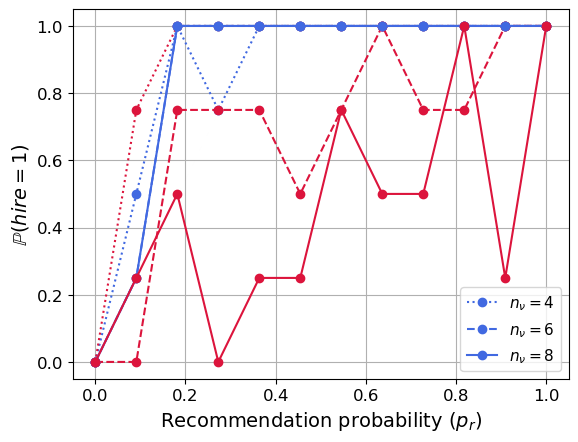

In [8]:
for i in range(success.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, success[:,i], marker='o', ls=ls[i], color='blue', label=label )
    plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color='red', label='' )

plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

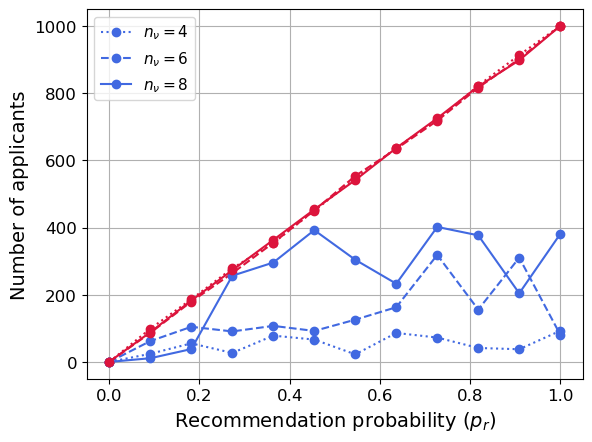

In [9]:
for i in range(sizes.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, sizes[:,i], marker='o', ls=ls[i], color='blue', label=label )
    plt.plot(p_recs, sizes_oracle[:,i], marker='o', ls=ls[i], color='red', label='' )

plt.ylabel("Number of applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

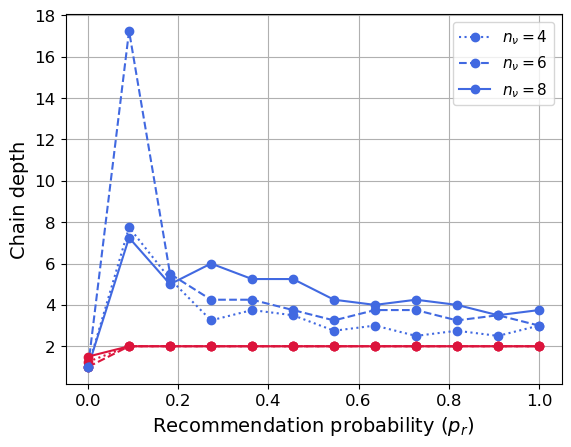

In [10]:
ls = ['dotted', '--', '-']
# ls = ['dotted' '--' '-']
ms = ['^', 's', 'o'] 
# label = "$n_\\nu = {}$".format(nνs)

for i in range(depths.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, depths[:,i], marker='o', ls=ls[i], color='blue', label=label )
    plt.plot(p_recs, depths_oracle[:,i], marker='o', ls=ls[i], color='red', label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

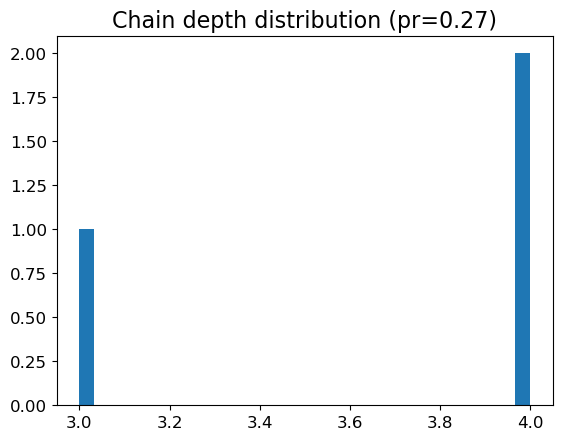

In [11]:
depth_succ = tuple(list( np.array(depths_dist[i])[successes_dist[i]] ) for i in range(len(depths_dist)) )
D = sh.invert_nested_dict( sh.nested_dict_from_list(depth_succ, p_recs, nνs) )

pr = p_recs[3]
plt.hist( D[4][pr], bins=30 )
plt.title(f"Chain depth distribution ({pr=:.2f})");

## Homophilic networks

In [11]:
def run_model_homophilic(n_nodes, k_avg, λ, nν, n_skill_groups=2, alpha=0.5, homophily=4, edgelist=None, n_skills=None, nodelist=None, **kw):
    if nodelist is None:
            nodelist = np.arange(n_nodes)
    pa, ph, skills = sample_application_and_hiring_probs(nodelist, λ, nν, n_skills=n_skills, n_groups=n_skill_groups, alpha=alpha, return_skills=True)

    # zero-homophily should be ER network
    if homophily == 0:
        edgelist = generate_erdos_renyi_edgelist(n_nodes, prob_edge=k_avg/n_nodes)
    else:
        edgelist = generate_homophilic_network_edgelist(skills, k_avg, homophily)        

    results = run_model(edgelist, application_probs=pa, hiring_probs=ph, return_chain_ends=True, **kw)
    chain_depth, chain_size, applicants, is_hired, chain_ends_nodes = results
    
    # Check if initial spreader and hired node are in the same skill group (homophilic hire)     
    initial_spreader, hired_node = chain_ends_nodes
    is_hire_in_spreader_group = False
    if hired_node is not None:
        initial_spreader, hired_node = initial_spreader[0], hired_node[0]
        skill_groups = majority_groups(skills, n_skill_groups)
        is_hire_in_spreader_group = skill_groups.loc[initial_spreader] == skill_groups.loc[hired_node]
            
    return chain_depth, chain_size, applicants, is_hired, is_hire_in_spreader_group 

### homophily vs recommendation prob

In [12]:
### SIMULATIONS 
np.random.seed(42) # for reproducibility

# grid parameters
grid_resolution = 50
p_recs = np.linspace(0.001, 0.999, num=grid_resolution)[::-1] 
homophilies = [0, 2, 4, 8, 12, np.inf]

# skills parameters
nν = 6 # 0.9 CI

# Partial function
f = partial(perform_independent_model_simulations, 
            n_simulations = N_SIMULATIONS * 2,
            new_edgelist_every = NEW_EDGELIST_EVERY,
            run_model_func = run_model_homophilic,
            λ = AVG_SKILLS,
            nν = nν, # num vacancy requirements
            alpha = ALPHA,
            n_skill_groups = N_SKILL_GROUPS,
            n_nodes = N_NODES,
            k_avg = K_AVG,
            return_chain_ends = True,
            )

## Perform experiments in parallel
print(f"TOTAL: {grid_resolution*len(homophilies)} tasks per model...")
parallel = Parallel(n_jobs=-1, prefer="processes", verbose=10)  # use all cores
vals = parallel(
    delayed(f)(recommendation_probs=pr, homophily=homophily)
    for pr in p_recs
    for homophily in homophilies
)

# Unzip values into different result diagnostics
depths_dist, sizes_tot_dist, sizes_dist, successes_dist, homophilic_hire_dist = zip(*vals)

# ## Save
fn_suffix = f'n_nodes={N_NODES}-k_avg={K_AVG}-avg_skills={AVG_SKILLS}-n_skill_groups={N_SKILL_GROUPS}-alpha={ALPHA}.npy'
fn_depth      = os.path.join( PATH, 'pr_vs_homophily', 'homophilic', 'chain_depths', fn_suffix )
fn_applicants = os.path.join( PATH, 'pr_vs_homophily', 'homophilic', 'applicants', fn_suffix )
fn_size       = os.path.join( PATH, 'pr_vs_homophily', 'homophilic', 'chain_size', fn_suffix )
fn_success    = os.path.join( PATH, 'pr_vs_homophily', 'homophilic', 'success_rate', fn_suffix )
fn_homo       = os.path.join( PATH, 'pr_vs_homophily', 'homophilic', 'homophilic_hire', fn_suffix )
save_experiment(fn_depth, depths_dist, p_recs, homophilies)
save_experiment(fn_applicants, sizes_dist, p_recs, homophilies)
save_experiment(fn_size, sizes_tot_dist, p_recs, homophilies)
save_experiment(fn_success, successes_dist, p_recs, homophilies)
save_experiment(fn_homo, homophilic_hire_dist, p_recs, homophilies)

print("Saved successfully!")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


TOTAL: 300 tasks per model...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 74.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 139.4min


Saved successfully!


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 153.4min finished


In [216]:
depths = np.mean(depths_dist, axis=1).reshape( len(p_recs), len(homophilies) )
success = np.mean(successes_dist, axis=1).reshape( len(p_recs), len(homophilies) )
sizes = np.mean(sizes_dist, axis=1).reshape( len(p_recs), len(homophilies) )
homophilic_hire = np.mean(homophilic_hire_dist, axis=1).reshape( len(p_recs), len(homophilies) )

depths_succ_dist = [list(np.array(v)[b]) for v,b in zip(depths_dist, successes_dist)]
homophilic_hire_succ_dist = [list(np.array(v)[b]) for v,b in zip(homophilic_hire_dist, successes_dist)]

# depths_succ = np.array([np.mean(s) for s in depths_succ_dist]).reshape( len(p_recs), len(k0_ranges) )

In [217]:
def proportions_by_case(d, h, H):
    """
    d, h: lists of length P*H (outer aligned). 
          Each d[i] is a list of ints; h[i] a same-length list of bools.
    H:    number of cases. Order is always p_h, i.e. idx % H = case.
    Returns a DataFrame: rows=int values, columns=case (0..H-1), values=proportion True.
    """
    assert len(d) == len(h)
    ints  = [x  for idx, (di, hi) in enumerate(zip(d, h)) for x in di]
    flags = [b  for idx, (di, hi) in enumerate(zip(d, h)) for b in hi]
    cases = [idx % H for idx, (di, hi) in enumerate(zip(d, h)) for _ in di]

    df = pd.DataFrame({"int": ints, "flag": flags, "case": cases})
    return df.groupby(["int", "case"])["flag"].mean().unstack("case").sort_index()

def proportions_by_case_hp(d, h, H):
    """
    d, h: lists of length P*H (outer aligned). 
          Each d[i] is a list of ints; h[i] a same-length list of bools.
    H:    number of cases. Order is h_p, i.e. idx // P = case.
    Returns a DataFrame: rows=int values, columns=case (0..H-1), values=proportion True.
    """
    assert len(d) == len(h)
    P = len(d) // H
    
    ints  = [x for idx, (di, hi) in enumerate(zip(d, h)) for x in di]
    flags = [b for idx, (di, hi) in enumerate(zip(d, h)) for b in hi]
    cases = [idx // P for idx, (di, hi) in enumerate(zip(d, h)) for _ in di]

    df = pd.DataFrame({"int": ints, "flag": flags, "case": cases})
    return df.groupby(["int", "case"])["flag"].mean().unstack("case").sort_index()

In [229]:
df.loc[:10]

,0.0,2.0,4.0,8.0,12.0,inf
int,,,,,,
2,0.285714,0.400000,0.500000,0.500000,0.250000,1.000000
3,0.302326,0.344828,0.434783,0.300000,0.222222,0.428571
4,0.436782,0.375000,0.454545,0.444444,0.428571,0.333333
5,0.363636,0.290909,0.377778,0.476190,0.333333,0.333333
6,0.416667,0.187500,0.315789,0.333333,0.571429,0.458333
7,0.166667,0.214286,0.363636,0.380952,0.450000,0.352941
8,0.500000,0.333333,0.111111,0.800000,0.375000,0.181818
9,1.000000,0.200000,0.600000,0.400000,0.416667,0.333333
10,0.000000,NaN,0.666667,0.600000,0.142857,0.500000


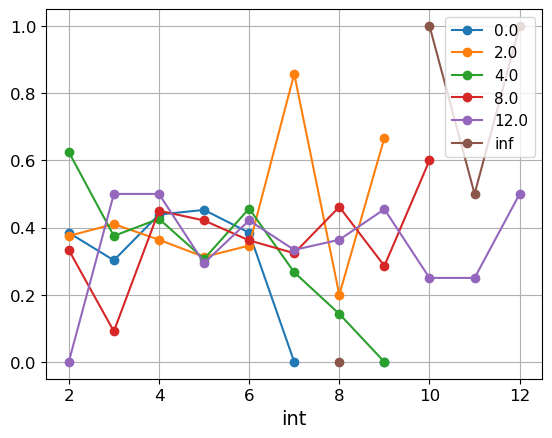

In [230]:
df = proportions_by_case_hp(depths_succ_dist, homophilic_hire_succ_dist, len(homophilies))
df.columns = homophilies
df.loc[:12].plot(marker='o')
# plt.xticks(df.index.values)
plt.grid();

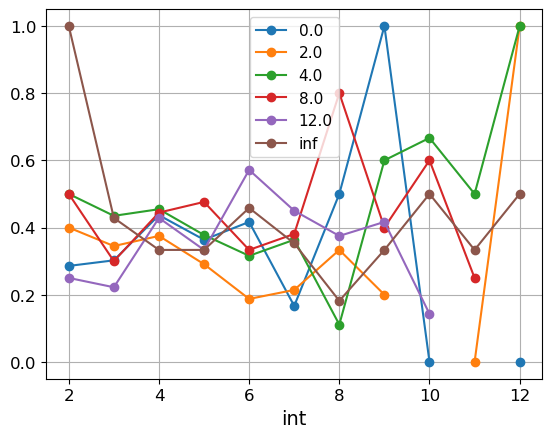

In [231]:
df = proportions_by_case(depths_succ_dist, homophilic_hire_succ_dist, len(homophilies))
df.columns = homophilies
df.loc[:12].plot(marker='o')
# plt.xticks(df.index.values)
plt.grid();

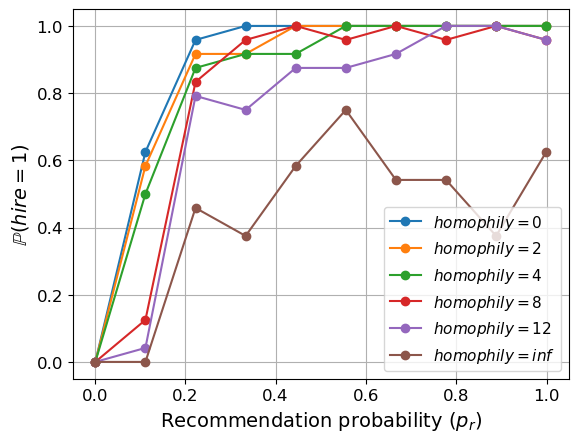

In [224]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, success[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

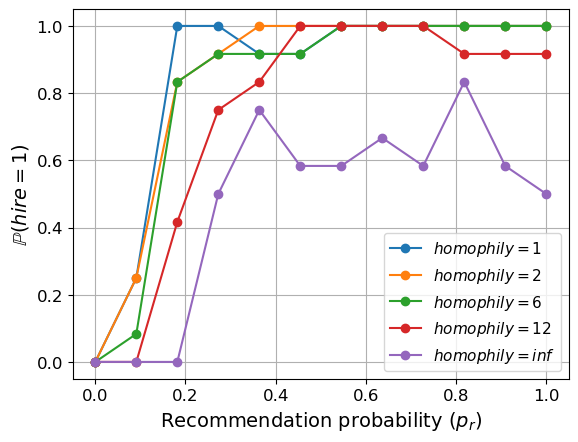

In [87]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, success[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

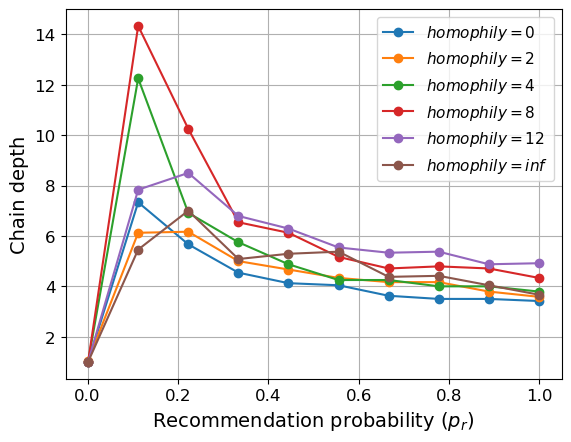

In [225]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, depths[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

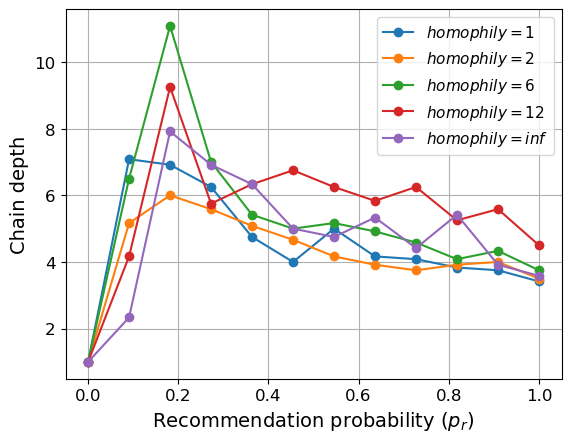

In [88]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, depths[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

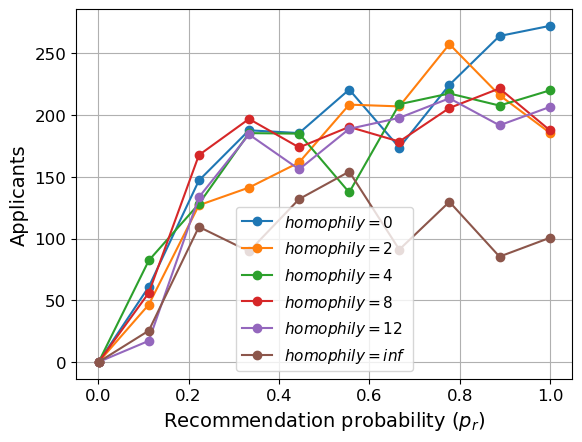

In [226]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, sizes[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

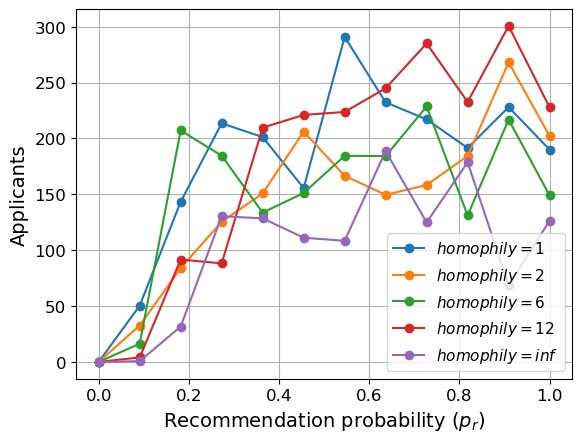

In [89]:
for i in range(success.shape[1]):
    # label = "$n_\\nu = {}$".format(nνs[i])
    label = "$homophily = {}$".format(homophilies[i])
    plt.plot(p_recs, sizes[:,i], marker='o', label=label ) # , ls=ls[i], color=cs[0],
    # plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

### skill correlation vs homophily

In [13]:
### SIMULATIONS 
np.random.seed(42) # for reproducibility

# grid parameters
grid_resolution = 16
alphas = np.linspace(0.2, 5, grid_resolution) # 0.1 => very strong correlation, 5 => very weak correlation
homophilies = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]

# skills parameters
nν = 6 # 0.9 CI
# ihcm parameter
pr = 0.2

# Partial function
f = partial(perform_independent_model_simulations, 
            n_simulations = N_SIMULATIONS,
            new_edgelist_every = NEW_EDGELIST_EVERY,
            run_model_func = run_model_homophilic,
            λ = AVG_SKILLS,
            nν = nν, # num vacancy requirements            
            n_skill_groups = N_SKILL_GROUPS,
            n_nodes = N_NODES,
            k_avg = K_AVG,
            recommendation_probs = pr,
            return_chain_ends = True,
            )

## Perform experiments in parallel
print(f"TOTAL: {grid_resolution*len(homophilies)} tasks per model...")
parallel = Parallel(n_jobs=-1, prefer="processes", verbose=5)  # use all cores
vals = parallel(
    delayed(f)(alpha=alpha, homophily=homophily)
    for alpha in alphas
    for homophily in homophilies
)

# Unzip values into different result diagnostics
depths_dist, sizes_tot_dist, sizes_dist, successes_dist, homophilic_hire_dist = zip(*vals)

# ## Save
fn_suffix = f'n_nodes={N_NODES}-k_avg={K_AVG}-avg_skills={AVG_SKILLS}-n_skill_groups={N_SKILL_GROUPS}-alpha={ALPHA}.npy'
fn_depth      = os.path.join( PATH, 'alpha_vs_homophily', 'homophilic', 'chain_depths', fn_suffix )
fn_applicants = os.path.join( PATH, 'alpha_vs_homophily', 'homophilic', 'applicants', fn_suffix )
fn_size       = os.path.join( PATH, 'alpha_vs_homophily', 'homophilic', 'chain_size', fn_suffix )
fn_success    = os.path.join( PATH, 'alpha_vs_homophily', 'homophilic', 'success_rate', fn_suffix )
fn_homo       = os.path.join( PATH, 'alpha_vs_homophily', 'homophilic', 'homophilic_hire', fn_suffix )
save_experiment(fn_depth, depths_dist, alphas, homophilies)
save_experiment(fn_applicants, sizes_dist, alphas, homophilies)
save_experiment(fn_size, sizes_tot_dist, alphas, homophilies)
save_experiment(fn_success, successes_dist, alphas, homophilies)
save_experiment(fn_homo, homophilic_hire_dist, alphas, homophilies)

print("Saved successfully!")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


TOTAL: 224 tasks per model...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 49.8min


Saved successfully!


[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed: 75.4min finished


In [ ]:
depths = np.mean(depths_dist, axis=1).reshape( len(alphas), len(homophilies) )
success = np.mean(successes_dist, axis=1).reshape( len(alphas), len(homophilies) )
sizes = np.mean(sizes_dist, axis=1).reshape( len(alphas), len(homophilies) )
homophilic_hire = np.mean(homophilic_hire_dist, axis=1).reshape( len(alphas), len(homophilies) )

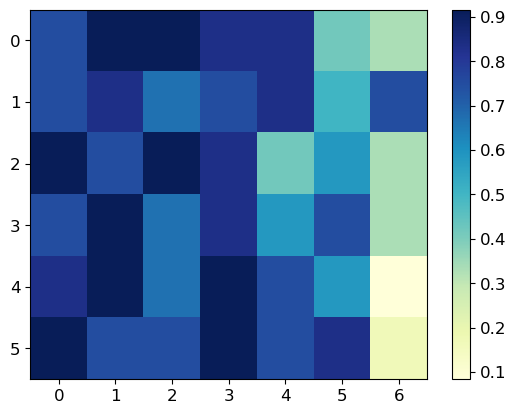

In [237]:
plt.imshow(success , cmap="YlGnBu", aspect='auto')
plt.colorbar();

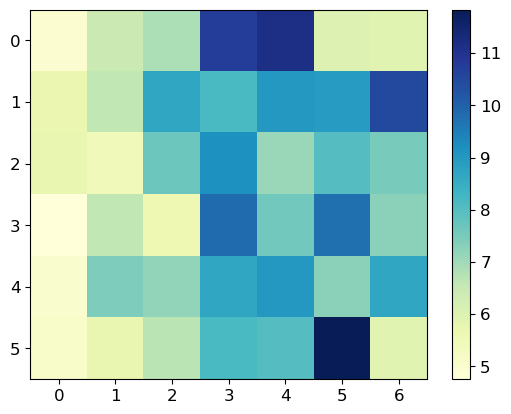

In [238]:
plt.imshow(depths , cmap="YlGnBu", aspect='auto')
plt.colorbar()

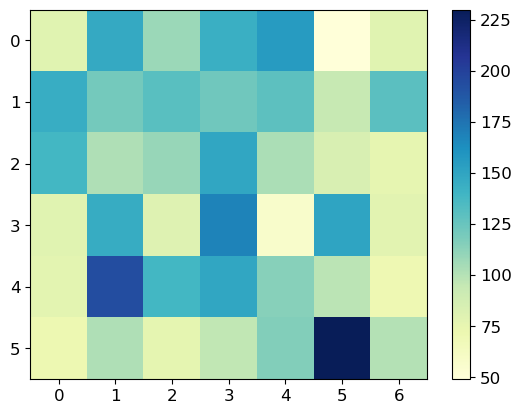

In [239]:
plt.imshow(sizes , cmap="YlGnBu", aspect='auto')
plt.colorbar()

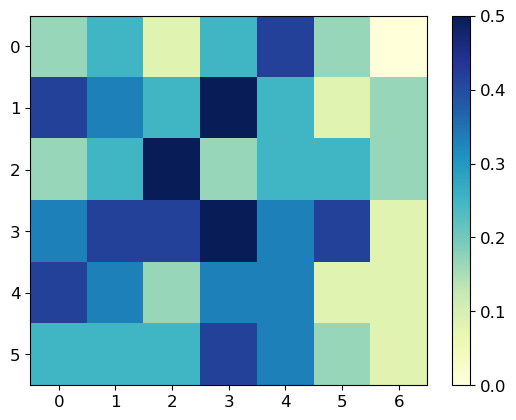

In [240]:
plt.imshow(homophilic_hire , cmap="YlGnBu", aspect='auto')
plt.colorbar()

## Real networks

In [17]:
# For reference for more real networks (not used)
network_names = [
    "copenhagen/sms", # directed, phone sms, n=568, m=24k
    "copenhagen/fb_friends", # undirected, friendships, n=800, m=6.4k
    "copenhagen/calls", # undirected, phone calls, n=536, m=3.6k
    "copenhagen/bt", # undirected, blue-tooth proximity, n=692, m=2.4M
    "social_location/brightkite", # undirected, friendships, n=58k, n=48k
    "social_location/gowalla", # undirected, friendships, n=196k, n=1.9M
    "twitter", # directed, followerships, n=465k, m=834k
    "twitter_15m", # directed, followerships, n=87k, m=6M
    "lastfm_aminer", # directed, followerships, n=136k, m=1.6M
    "livemocha", # undirected, friendships, n=104k, m=2.2M
    "douban", # undirected, friendships, n=154k, m=37k
    "uni_email", # directed, n=1.1k, m=10k
]

There are 7 selected networks


('uni_email', 1133, 10903)

In [70]:
### SIMULATIONS
np.random.seed(42) # for reproducibility

# grid parameters
grid_resolution = 50
p_recs = np.linspace(0.001, 0.999, num=grid_resolution)[::-1] 

print(f"TOTAL: {grid_resolution*len(VACANCY_REQUIREMENTS)} tasks per model...")
parallel = Parallel(n_jobs=-1, prefer="processes", verbose=6)  # use all cores
for network_name in REAL_NETWORK_SELECTION:
    # import network
    edgelist, nodelist = import_graphtool_network(network_name, directed=False)
    print(f"\nSelected {network_name} network with {len(nodelist)} nodes and {len(edgelist)} edges.")
    
    # get degree range for initial spreader
    degrees = edgelist.groupby('source').size()
    k_min = max(2, degrees.quantile(0.25))
    k_max = max(k_min+2, degrees.quantile(0.75))
    k0_range = (k_min, k_max)

    if network_name == 'twitter_15m':
        n_simulations = N_SIMULATIONS // 2
    else:
        n_simulations = N_SIMULATIONS
    
    # oracle
    def oracle_generator():
        # nodes = import_graphtool_network(name, directed=False)[1]
        oracle_degree = round(ORACLE_REACH  * len(nodelist))
        return generate_oracle(nodelist, oracle_degree)
        
    # Partial functions
    # IHC model
    f_ihc = partial(perform_independent_model_simulations, 
                n_simulations = n_simulations,                
                edgelist = edgelist,
                λ = AVG_SKILLS,
                run_model_func = run_model_skills,
                nodelist = nodelist,
                k0_range=k0_range,
                )
    # Oracle
    f_oracle = partial(perform_independent_model_simulations, 
                n_simulations = n_simulations,
                new_edgelist_every = NEW_EDGELIST_EVERY,
                edgelist_generator = oracle_generator,
                λ = AVG_SKILLS,
                run_model_func = run_model_oracle_skills,
                nodelist = nodelist,
                )
    
    ## Perform experiments in parallel    
    print(" - IHCM")
    vals_ihc = parallel(
        delayed(f_ihc)(recommendation_probs=pr, nν=nν)
        for pr in p_recs
        for nν in VACANCY_REQUIREMENTS
    )
    print(" - Oracle")
    vals_oracle = parallel(
        delayed(f_oracle)(recommendation_probs=pr, nν=nν)
        for pr in p_recs
        for nν in VACANCY_REQUIREMENTS
    )
    
    # Unzip values into different result diagnostics
    depths_dist, sizes_tot_dist, sizes_dist, successes_dist = zip(*vals_ihc)
    depths_oracle_dist, sizes_tot_oracle_dist, sizes_oracle_dist, successes_oracle_dist = zip(*vals_oracle)
    
    ## Save
    # IHC
    fn_suffix = f'n_nodes={len(nodelist)}-k_avg={round(degrees.mean())}-avg_skills={AVG_SKILLS}.npy'
    fn_depth      = os.path.join( PATH, 'pr_vs_requirements', 'real_network', network_name.replace('/','-'), 'chain_depths', fn_suffix )
    fn_applicants = os.path.join( PATH, 'pr_vs_requirements', 'real_network', network_name.replace('/','-'), 'applicants', fn_suffix )
    fn_size       = os.path.join( PATH, 'pr_vs_requirements', 'real_network', network_name.replace('/','-'), 'chain_size', fn_suffix )
    fn_success    = os.path.join( PATH, 'pr_vs_requirements', 'real_network', network_name.replace('/','-'), 'success_rate', fn_suffix )
    save_experiment(fn_depth, depths_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_applicants, sizes_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_size, sizes_tot_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_success, successes_dist, p_recs, VACANCY_REQUIREMENTS)
    
    # Oracle
    k_oracle = round( len(nodelist) * ORACLE_REACH )
    fn_suffix_oracle = f'n_nodes={len(nodelist)}-k_avg={k_oracle}-avg_skills={AVG_SKILLS}'
    fn_oracle_depth      = os.path.join( PATH, 'pr_vs_requirements', 'real_network_oracle', network_name.replace('/','-'), 'chain_depths', fn_suffix_oracle )
    fn_oracle_applicants = os.path.join( PATH, 'pr_vs_requirements', 'real_network_oracle', network_name.replace('/','-'), 'applicants', fn_suffix_oracle )
    fn_oracle_size       = os.path.join( PATH, 'pr_vs_requirements', 'real_network_oracle', network_name.replace('/','-'), 'chain_size', fn_suffix_oracle )
    fn_oracle_success    = os.path.join( PATH, 'pr_vs_requirements', 'real_network_oracle', network_name.replace('/','-'), 'success_rate', fn_suffix_oracle )
    save_experiment(fn_oracle_depth, depths_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_oracle_applicants, sizes_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_oracle_size, sizes_tot_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
    save_experiment(fn_oracle_success, successes_oracle_dist, p_recs, VACANCY_REQUIREMENTS)
    
    print("Saved successfully!")

TOTAL: 150 tasks per model...

Selected copenhagen/sms network with 568 nodes and 1394 edges.
 - IHCM


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   51.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


 - Oracle


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   36.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Saved successfully!

Selected uni_email network with 1133 nodes and 10903 edges.
 - IHCM


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


 - Oracle


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   57.2s finished


Saved successfully!

Selected twitter_15m network with 87569 nodes and 9416551 edges.
 - IHCM


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/blaskolic/miniconda3/envs/networks/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 117.8min


 - Oracle


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 174.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 19.1min


Saved successfully!


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 27.8min finished


In [74]:
from oracle_probabilities import prob_successful_hire, prob_successful_hire_approx
### Theoretical probabilities
# Use approximation if N > 10k
from oracle_probabilities import prob_successful_hire, prob_successful_hire_approx

n = len(nodelist)
m = round(n * ORACLE_REACH)

prs = np.linspace(0,1, 100)
lines = []
for nν in tqdm(VACANCY_REQUIREMENTS):
    if n > 10_000:
        lines.append( [ prob_successful_hire_approx(n,m,pr,AVG_SKILLS,nν) for pr in prs ] )    
    else:
        lines.append( [ prob_successful_hire(n,m,pr,AVG_SKILLS,nν) for pr in prs ] )    
lines = np.array(lines)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


In [75]:
## Unzip values into different result diagnostics
depths_dist, sizes_tot_dist, sizes_dist, successes_dist = zip(*vals_ihc)
depths_dist_oracle, sizes_tot_dist_oracle, sizes_dist_oracle, successes_dist_oracle = zip(*vals_oracle)

depths  = np.mean(depths_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
success = np.mean(successes_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
sizes = np.mean(sizes_dist, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )

depths_oracle  = np.mean(depths_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
success_oracle = np.mean(successes_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )
sizes_oracle = np.mean(sizes_dist_oracle, axis=1).reshape( len(p_recs), len(VACANCY_REQUIREMENTS) )

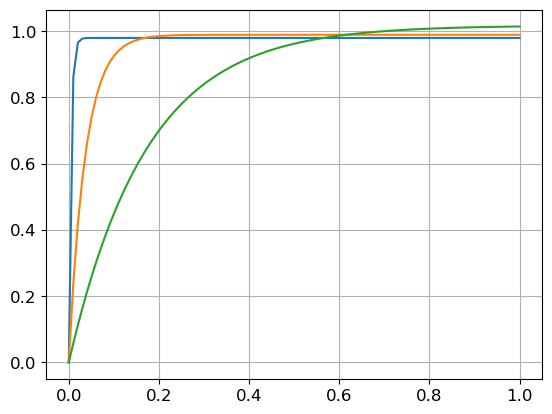

In [76]:
plt.plot(prs, lines.T)
plt.grid()

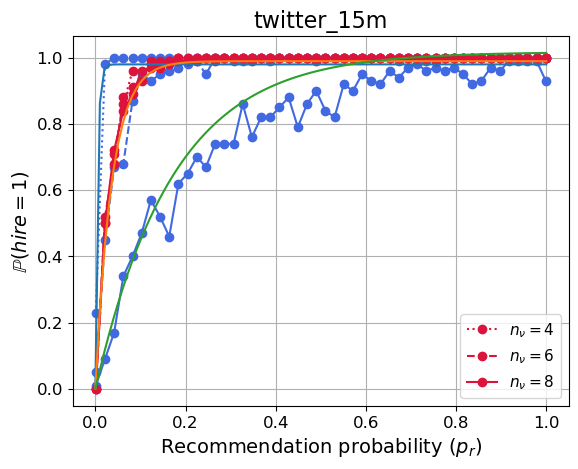

In [78]:
for i in range(success.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, success[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.plot(prs, lines.T)
plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.title(network_name)
plt.legend();

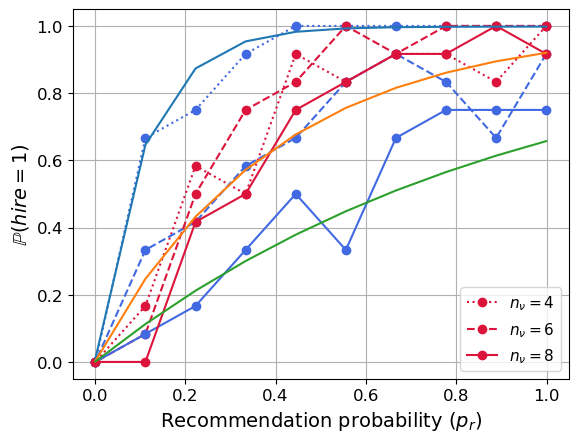

In [255]:
for i in range(success.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, success[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.plot(p_recs, lines.T)
plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

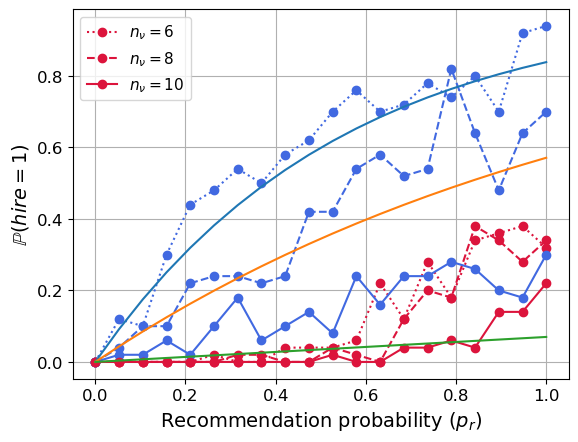

In [307]:
for i in range(success.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, success_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, success[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.plot(p_recs, lines.T)
plt.ylabel("$\mathbb{P}(hire = 1)$")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

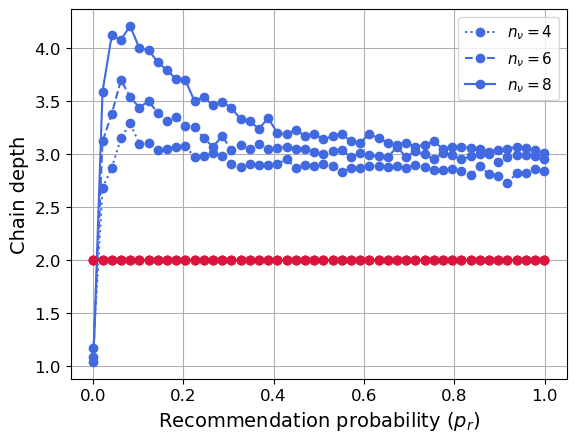

In [79]:
ls = ['dotted', '--', '-']
# ls = ['dotted' '--' '-']
ms = ['^', 's', 'o'] 
# label = "$n_\\nu = {}$".format(nνs)

for i in range(depths.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, depths[:,i], marker='o', ls=ls[i], color=cs[0], label=label )
    plt.plot(p_recs, depths_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

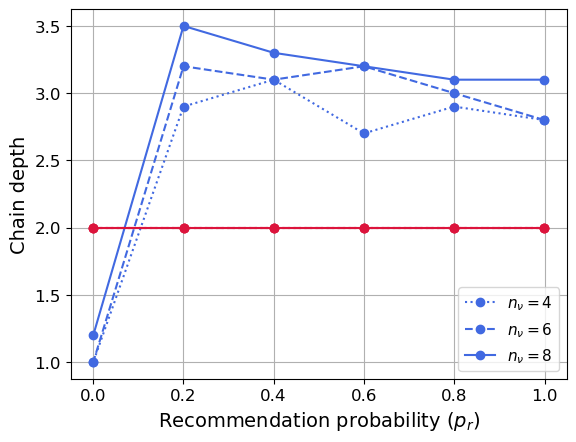

In [68]:
ls = ['dotted', '--', '-']
# ls = ['dotted' '--' '-']
ms = ['^', 's', 'o'] 
# label = "$n_\\nu = {}$".format(nνs)

for i in range(depths.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, depths[:,i], marker='o', ls=ls[i], color=cs[0], label=label )
    plt.plot(p_recs, depths_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

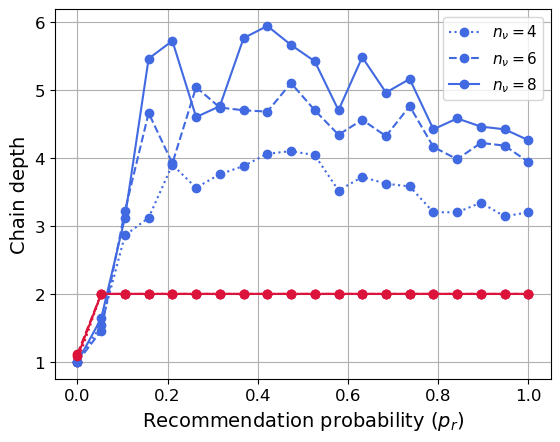

In [302]:
ls = ['dotted', '--', '-']
# ls = ['dotted' '--' '-']
ms = ['^', 's', 'o'] 
# label = "$n_\\nu = {}$".format(nνs)

for i in range(depths.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, depths[:,i], marker='o', ls=ls[i], color=cs[0], label=label )
    plt.plot(p_recs, depths_oracle[:,i], marker='o', ls=ls[i], color=cs[1], label='' )

plt.ylabel("Chain depth")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

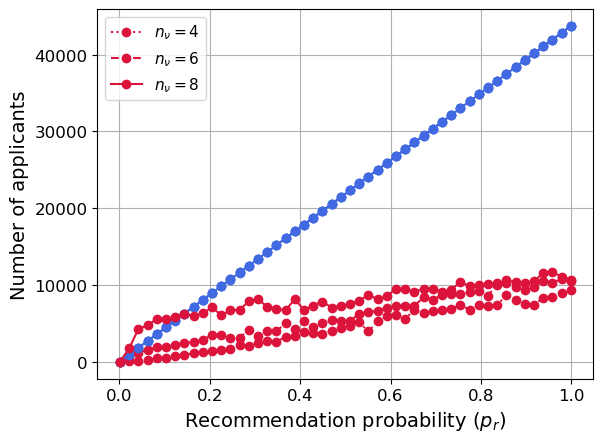

In [80]:
for i in range(sizes.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, sizes_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, sizes[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.ylabel("Number of applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

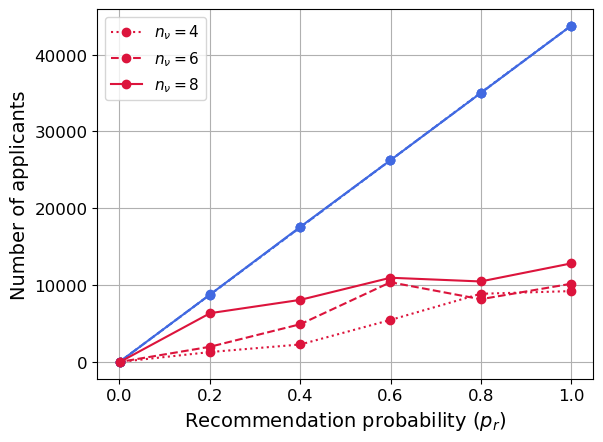

In [69]:
for i in range(sizes.shape[1]):
    label = "$n_\\nu = {}$".format(VACANCY_REQUIREMENTS[i])
    plt.plot(p_recs, sizes_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, sizes[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.ylabel("Number of applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

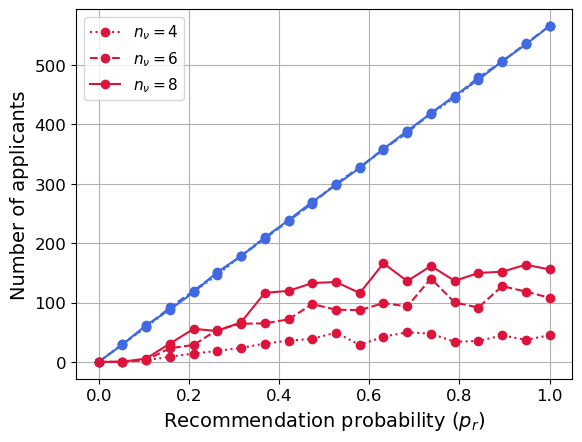

In [303]:
for i in range(sizes.shape[1]):
    label = "$n_\\nu = {}$".format(nνs[i])
    plt.plot(p_recs, sizes_oracle[:,i], marker='o', ls=ls[i], color=cs[0], label='' )
    plt.plot(p_recs, sizes[:,i], marker='o', ls=ls[i], color=cs[1], label=label )

plt.ylabel("Number of applicants")
plt.xlabel("Recommendation probability ($p_r$)")
plt.legend()
plt.grid()
plt.legend();

In [8]:
## PARAMS ## 
# Select network
name = networks_names_selection[3]
# Read network
edgelist, nodelist = import_graphtool_network(name)
# Compute degree distribution
degree_dist = edgelist.groupby('source').size()

# Model hyperparameters
λ = 3 # agent skillset avg size and spread
ρ = 0.2 # oracle population reach
CIs = [0.9, 0.99, 0.999] # Vacancy specificities (in confidence intervals of Poisson(λ)
# Degree range for initial spreader (25-75 quantile, with a minimum degree of 2):
k_min = max(2, degree_dist.quantile(0.25))
k_max = max(k_min+2, degree_dist.quantile(0.75))
k_range = (k_min, k_max)

# Grid parameters
n_vals = 41 # 31
p_rs = np.linspace(0.0, 1.0, n_vals) # Recommendation probabilities
n_sims = 50 # 25 # number of skillset draws
n_reps = 20 # 20 # number of initial spreaders (and population selection) for each draw

## PRINT SUMMARY
print(f"""
Network properties:
   - name: {name.capitalize()}
   - nodes: {len(nodelist)}
   - edges: {len(edgelist)}
   - avg_degree : {degree_dist.mean().round(2)}
   - 25-75 degree range: { int(degree_dist.quantile(0.25)) }-{ int(degree_dist.quantile(0.75)) }

Model parameters:
   - λ: {λ}
   - ρ: {ρ}
   - specificities CIs: {CIs}
   - k0 range: {k_range}

Grid hyperparameters:
   - number of model draws: {n_sims}
   - number of repetitions per draw: {n_reps}
   - total simulations per parameter: {n_reps * n_sims}

""")


Network properties:
   - name: Uni_email
   - nodes: 1133
   - edges: 10903
   - avg_degree : 9.62
   - 25-75 degree range: 3-13

Model parameters:
   - λ: 3
   - ρ: 0.2
   - specificities CIs: [0.9, 0.99, 0.999]
   - k0 range: (3.0, 13.0)

Grid hyperparameters:
   - number of model draws: 50
   - number of repetitions per draw: 20
   - total simulations per parameter: 1000




In [40]:
%%time 
## SIMULATIONS
# Simulate IHC model in the grid
results = grid.run_ihcm_grid(name, p_rs, CIs, λ, n_sims, n_reps, k_range)
(
    results_hiring_social,
    results_depths_social, 
    results_applicants_social,
    results_recommenders_social,
) = results

# Simulate Oracle system in the grid
results = grid.run_oracle_grid(name, ρ, p_rs, CIs, λ, n_sims, 2*n_reps, )
(
    results_hiring_oracle,
    results_depths_oracle, 
    results_applicants_oracle,
    results_recommenders_oracle,
) = results


Network properties:
   - name: Uni_email
   - nodes: 1133
   - edges: 10903
   - avg_degree : 9.62
   - 25-75 degree range: 3-13

Model parameters:
   - λ: 3
   - ρ: 0.2
   - specificities CIs: [0.9, 0.99, 0.999]
   - k0 range: (3.0, 13.0)

Grid hyperparameters:
   - number of model draws: 50
   - number of repetitions per draw: 20
   - total simulations per parameter: 1000




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [05:06<00:00,  7.47s/it]

CPU times: user 16min 28s, sys: 888 ms, total: 16min 29s
Wall time: 16min 30s


## Saving

In [ ]:
### TODO ###

In [ ]:
%%time
#### SAVING #### 
save_ = True
if save_:
    # TODO: Save resulting dictionary
    
    # prototypes
    # 1. Using json
    import json
    # data = {'another_dict': {'a': 0, 'b': 1}, 'a_list': [0, 1, 2, 3]}
    
    # Saving
    suffix_s = '_lambda={}_kavg={}_n_sims={}_ER_n_nodes={}'.format( λ, k_avg , n_sims*n_reps, n_nodes, )
    suffix_o = '_lambda={}_rho={}_n_sims={}_ER_n_nodes={}'.format( λ, round(ρ_o,2) , n_sims*n_reps, n_nodes )
    # p_app_min={}_p_app_max={}_dp_app={}_p_act_min={}_p_act_max={}_dp_act={}
    filename_d_s = '../outputs/social_chain_depths'+suffix_s
    filename_d_o = '../outputs/oracle_chain_depths'+suffix_o
    
    with open(filename_d_s+'.json', 'w') as f: 
        json.dump(results_depths_social2, f)
    with open(filename_d_o+'.json', 'w') as f: 
        json.dump(results_depths_oracle2, f)
    
    filename_h_s = '../outputs/social_is_hired'+suffix_s
    filename_h_o = '../outputs/oracle_is_hired'+suffix_o
    
    with open(filename_h_s+'.json', 'w') as f: 
        json.dump(results_hiring_social2, f)
    with open(filename_h_o+'.json', 'w') as f: 
        json.dump(results_hiring_oracle2, f)
    
    filename_r_s = '../outputs/social_num_applicants'+suffix_s
    filename_r_o = '../outputs/oracle_num_applicants'+suffix_o
    
    with open(filename_r_s+'.json', 'w') as f: 
        json.dump(results_applicants_social2, f)
    with open(filename_r_o+'.json', 'w') as f: 
        json.dump(results_applicants_oracle2, f)

In [753]:
# %%time
# #### SAVING #### 
# save_ = True
# if save_:
#     # TODO: Save resulting dictionary
    
#     # prototypes
#     # 1. Using json
#     import json
#     # data = {'another_dict': {'a': 0, 'b': 1}, 'a_list': [0, 1, 2, 3]}
    
#     # Saving
#     suffix_s = '_lambda={}_kavg={}_n_sims={}_ER_n_nodes={}'.format( λ, k_avg , n_sims*n_reps, n_nodes, )
#     suffix_o = '_lambda={}_rho={}_n_sims={}_ER_n_nodes={}'.format( λ, round(ρ_o,2) , n_sims*n_reps, n_nodes )
#     # p_app_min={}_p_app_max={}_dp_app={}_p_act_min={}_p_act_max={}_dp_act={}
#     filename_d_s = '../outputs/social_chain_depths'+suffix_s
#     filename_d_o = '../outputs/oracle_chain_depths'+suffix_o
    
#     with open(filename_d_s+'.json', 'w') as f: 
#         json.dump(results_depths_social2, f)
#     with open(filename_d_o+'.json', 'w') as f: 
#         json.dump(results_depths_oracle2, f)
    
#     filename_h_s = '../outputs/social_is_hired'+suffix_s
#     filename_h_o = '../outputs/oracle_is_hired'+suffix_o
    
#     with open(filename_h_s+'.json', 'w') as f: 
#         json.dump(results_hiring_social2, f)
#     with open(filename_h_o+'.json', 'w') as f: 
#         json.dump(results_hiring_oracle2, f)
    
#     filename_r_s = '../outputs/social_num_applicants'+suffix_s
#     filename_r_o = '../outputs/oracle_num_applicants'+suffix_o
    
#     with open(filename_r_s+'.json', 'w') as f: 
#         json.dump(results_applicants_social2, f)
#     with open(filename_r_o+'.json', 'w') as f: 
#         json.dump(results_applicants_oracle2, f)

CPU times: user 204 ms, sys: 4.86 ms, total: 209 ms
Wall time: 209 ms


In [34]:
# %%time
# #### SAVING ####
# save_ = True
# if save_:
#     # TODO: Save resulting dictionary
    
#     # prototypes
#     # 1. Using json
#     import json
#     # data = {'another_dict': {'a': 0, 'b': 1}, 'a_list': [0, 1, 2, 3]}
    
#     # Saving
#     suffix_s = '_lambda={}_pr={}_n_sims={}_ER_n_nodes={}'.format( λ, round(p_recommendation,2) , n_sims*n_reps, n_nodes, )
#     suffix_o = '_lambda={}_pr={}_n_sims={}_ER_n_nodes={}'.format( λ, round(p_recommendation_oracle,2) , n_sims*n_reps, n_nodes )
#     # p_app_min={}_p_app_max={}_dp_app={}_p_act_min={}_p_act_max={}_dp_act={}
#     filename_d_s = '../outputs/social_chain_depths'+suffix_s
#     filename_d_o = '../outputs/oracle_chain_depths'+suffix_o
    
#     with open(filename_d_s+'.json', 'w') as f: 
#         json.dump(results_depths_social, f)
#     with open(filename_d_o+'.json', 'w') as f: 
#         json.dump(results_depths_oracle, f)
    
#     filename_h_s = '../outputs/social_is_hired'+suffix_s
#     filename_h_o = '../outputs/oracle_is_hired'+suffix_o
    
#     with open(filename_h_s+'.json', 'w') as f: 
#         json.dump(results_hiring_social, f)
#     with open(filename_h_o+'.json', 'w') as f: 
#         json.dump(results_hiring_oracle, f)
    
#     filename_r_s = '../outputs/social_num_applicants'+suffix_s
#     filename_r_o = '../outputs/oracle_num_applicants'+suffix_o
    
#     with open(filename_r_s+'.json', 'w') as f: 
#         json.dump(results_applicants_social, f)
#     with open(filename_r_o+'.json', 'w') as f: 
#         json.dump(results_applicants_oracle, f)

In [35]:
# def condense_results( results, func=np.mean ):
#     ρs = list(results.keys())
#     condensed_results = [ [ func( results[ρ][CI]) for ρ in ρs] for CI in results[ρs[0]].keys() ]
#     return condensed_results